<a href="https://colab.research.google.com/github/AntoninaRemizova/ML/blob/main/ML_class_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install scikit-image

In [2]:
!pip install scikit-image opencv-python seaborn pandas numpy matplotlib scikit-learn

# Импорт

In [36]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from skimage.feature import hog
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import rgb2gray, gray2rgb
from skimage import exposure

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (classification_report, confusion_matrix,
                            roc_auc_score, roc_curve, accuracy_score,
                            precision_recall_curve, average_precision_score)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import joblib
import cv2
from glob import glob
import zipfile
import io
from PIL import Image

np.random.seed(42)

In [4]:
!wget -q https://github.com/AntoninaRemizova/ML/archive/refs/heads/main.zip

In [5]:
with zipfile.ZipFile('main.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/ml_data')
import shutil

tiger_files = glob('/content/ml_data/ML-main/tiger/*.jpg') + glob('/content/ml_data/ML-main/tiger/*.jpeg') + glob('/content/ml_data/ML-main/tiger/*.png')
for i, file_path in enumerate(tiger_files[:100]):
    shutil.copy(file_path, f'/content/data/tiger/tiger_{i:03d}.jpg')

zebra_files = glob('/content/ml_data/ML-main/zebra/*.jpg') + glob('/content/ml_data/ML-main/zebra/*.jpeg') + glob('/content/ml_data/ML-main/zebra/*.png')
for i, file_path in enumerate(zebra_files[:100]):
    shutil.copy(file_path, f'/content/data/zebra/zebra_{i:03d}.jpg')

tiger_files = glob('/content/data/tiger/*.jpg') + glob('/content/data/tiger/*.jpeg') + glob('/content/data/tiger/*.png')
zebra_files = glob('/content/data/zebra/*.jpg') + glob('/content/data/zebra/*.jpeg') + glob('/content/data/zebra/*.png')

print(f"  Тигры: {len(tiger_files)}")
print(f"  Зебры: {len(zebra_files)}")

  Тигры: 60
  Зебры: 60


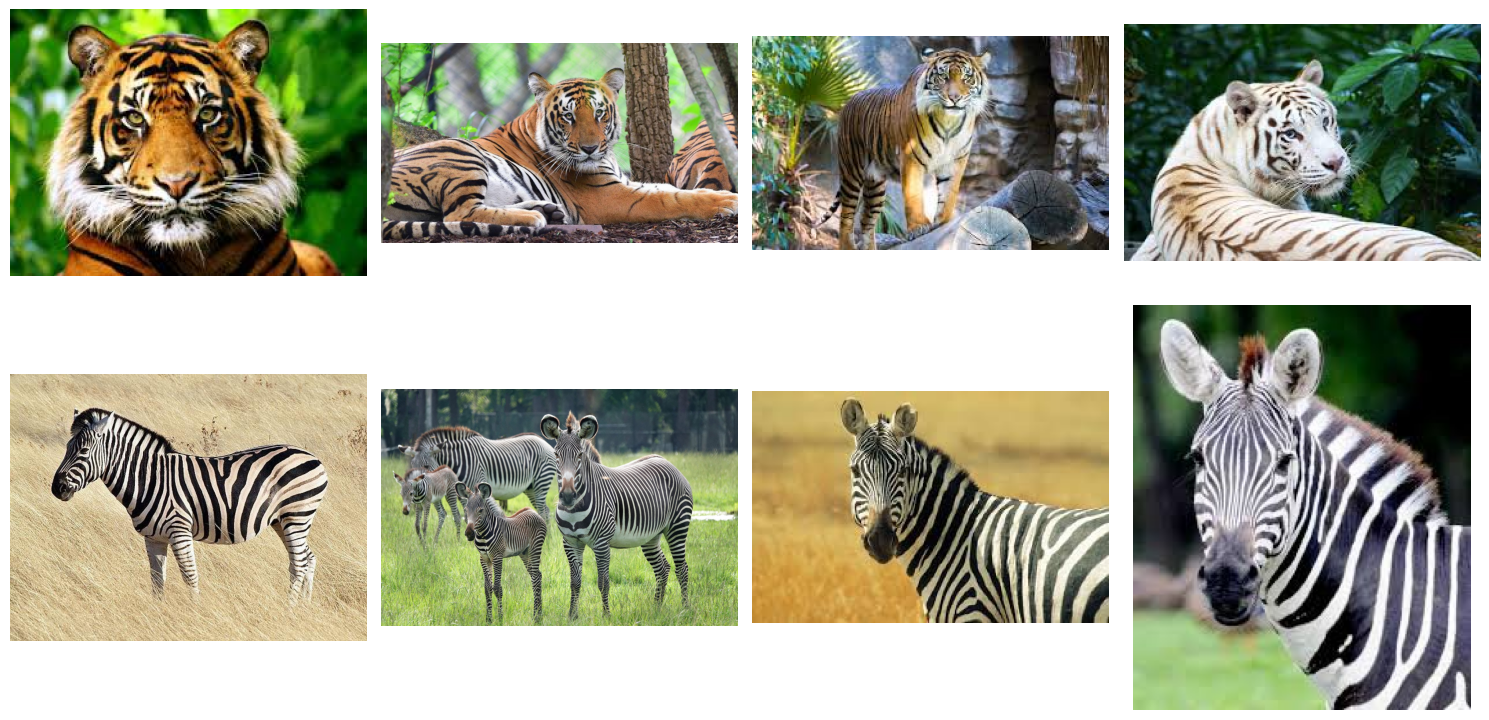

In [6]:
fig, axes = plt.subplots(2, 4, figsize=(15, 8))

for i in range(4):
    if i < len(tiger_files):
        img = imread(tiger_files[i])
        axes[0, i].imshow(img)
        axes[0, i].axis('off')

for i in range(4):
    if i < len(zebra_files):
        img = imread(zebra_files[i])
        axes[1, i].imshow(img)
        axes[1, i].axis('off')

plt.tight_layout()
plt.show()

# HOG

In [7]:
def extract_hog_features(image_path, target_size=(128, 128),
                        orientations=9, pixels_per_cell=(16, 16),
                        cells_per_block=(2, 2), visualize=False):
    try:
        img = imread(image_path)

        if img.shape[-1] == 4:
            img = img[:, :, :3]

        if len(img.shape) == 3 and img.shape[-1] == 3:
            gray_img = rgb2gray(img)
        else:
            gray_img = img

        resized_img = resize(gray_img, target_size, anti_aliasing=True)
        resized_img = exposure.equalize_adapthist(resized_img, clip_limit=0.03)

        if visualize:
            features, hog_image = hog(
                resized_img,
                orientations=orientations,
                pixels_per_cell=pixels_per_cell,
                cells_per_block=cells_per_block,
                visualize=True,
                block_norm='L2-Hys',
                feature_vector=True
            )
            return features, hog_image, resized_img
        else:
            features = hog(
                resized_img,
                orientations=orientations,
                pixels_per_cell=pixels_per_cell,
                cells_per_block=cells_per_block,
                visualize=False,
                block_norm='L2-Hys',
                feature_vector=True
            )
            return features, None, resized_img

    except Exception as e:
        print(f"Ошибка {image_path}: {e}")
        return None, None, None

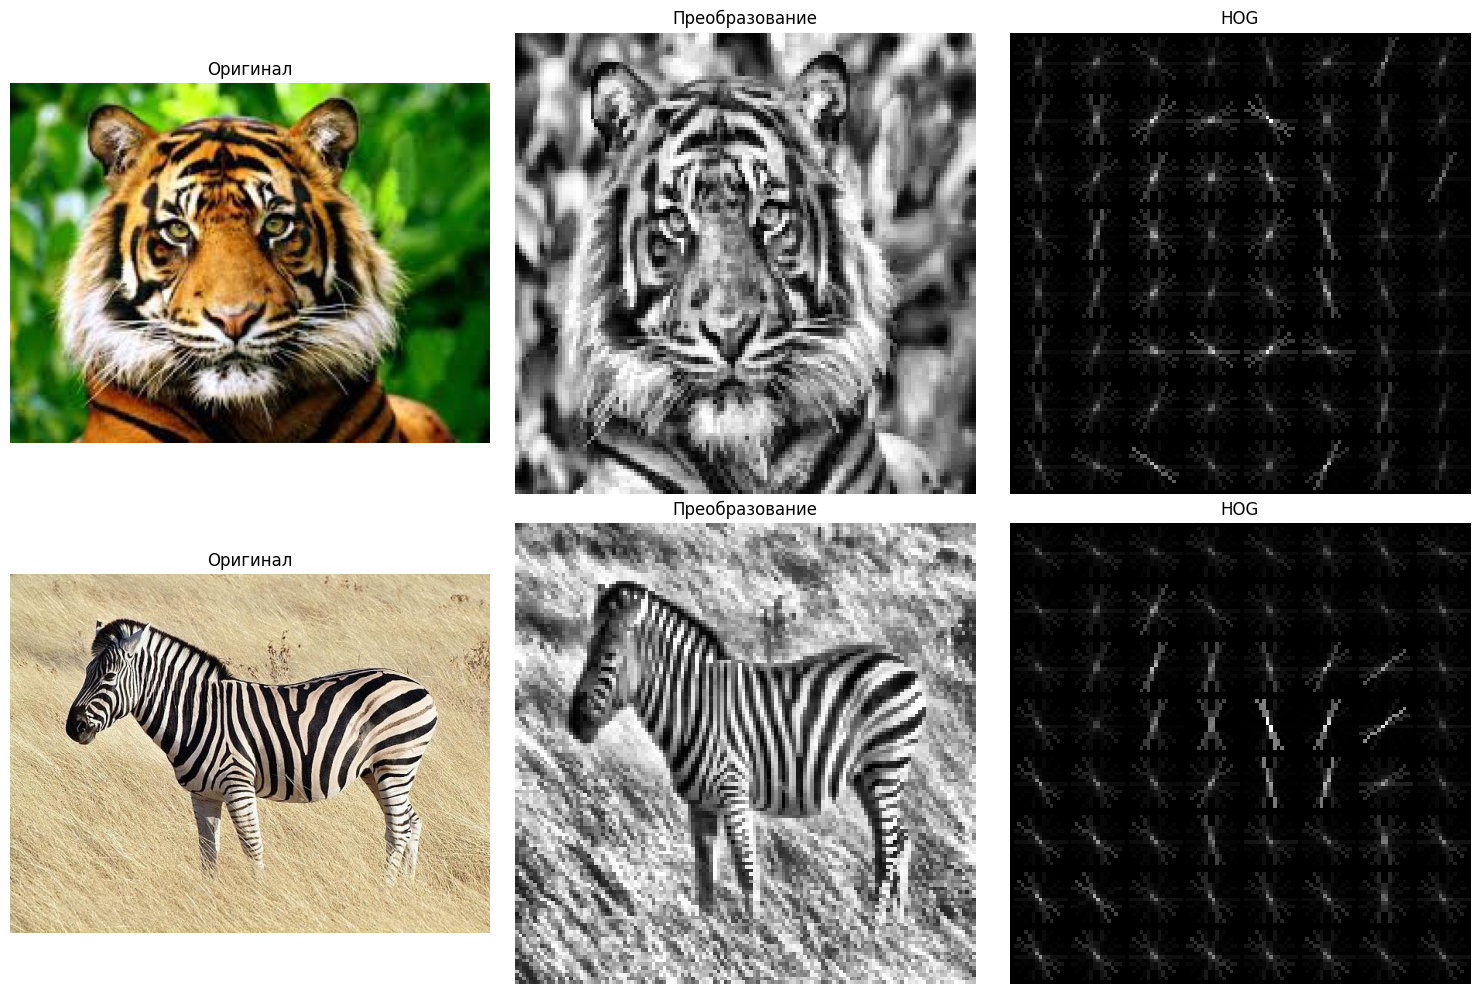

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

if len(tiger_files) > 0:
    hog_features_tiger, hog_image_tiger, processed_tiger = extract_hog_features(
        tiger_files[0], visualize=True
    )

    axes[0, 0].imshow(imread(tiger_files[0]))
    axes[0, 0].set_title('Оригинал')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(processed_tiger, cmap='gray')
    axes[0, 1].set_title('Преобразование')
    axes[0, 1].axis('off')

    axes[0, 2].imshow(hog_image_tiger, cmap='gray')
    axes[0, 2].set_title('HOG')
    axes[0, 2].axis('off')

if len(zebra_files) > 0:
    hog_features_zebra, hog_image_zebra, processed_zebra = extract_hog_features(
        zebra_files[0], visualize=True
    )

    axes[1, 0].imshow(imread(zebra_files[0]))
    axes[1, 0].set_title('Оригинал')
    axes[1, 0].axis('off')

    axes[1, 1].imshow(processed_zebra, cmap='gray')
    axes[1, 1].set_title('Преобразование')
    axes[1, 1].axis('off')

    axes[1, 2].imshow(hog_image_zebra, cmap='gray')
    axes[1, 2].set_title('HOG')
    axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

In [9]:
data = []
labels = []
filenames = []
failed_images = []

# класс 1 - тигр
for img_path in tqdm(tiger_files[:100]):
    features, _, _ = extract_hog_features(img_path, visualize=False)
    if features is not None:
        data.append(features)
        labels.append(1)
        filenames.append(os.path.basename(img_path))
    else:
        failed_images.append(img_path)

# класс 0 - зебра
for img_path in tqdm(zebra_files[:100]):
    features, _, _ = extract_hog_features(img_path, visualize=False)
    if features is not None:
        data.append(features)
        labels.append(0)
        filenames.append(os.path.basename(img_path))
    else:
        failed_images.append(img_path)

print(f"\nУспешно обработано: {len(data)} изображений")
print(f"Не удалось обработать: {len(failed_images)} изображений")
if failed_images:
    print("Проблемные файлы:", failed_images[:5])


100%|██████████| 60/60 [00:16<00:00,  3.54it/s]


Успешно обработано: 120 изображений
Не удалось обработать: 0 изображений


In [10]:
df = pd.DataFrame(data)
df['filename'] = filenames
df['label'] = labels
df['class_name'] = df['label'].map({1: 'tiger', 0: 'zebra'})

In [11]:
df

0         1         2         3         4         5         6  \
0    0.239451  0.118045  0.182312  0.032569  0.105332  0.049329  0.129038   
1    0.272698  0.272698  0.085242  0.074418  0.137565  0.078838  0.119708   
2    0.223416  0.146805  0.163909  0.124746  0.172369  0.135132  0.223010   
3    0.214525  0.071954  0.074654  0.098049  0.176959  0.175972  0.152785   
4    0.117121  0.039387  0.090057  0.120657  0.223591  0.148321  0.221668   
..        ...       ...       ...       ...       ...       ...       ...   
115  0.208995  0.169288  0.165607  0.188358  0.157094  0.123161  0.115398   
116  0.246764  0.182823  0.115952  0.029369  0.043127  0.031124  0.056448   
117  0.097367  0.135343  0.211065  0.160083  0.191834  0.091427  0.078690   
118  0.015239  0.051736  0.037825  0.153007  0.354022  0.354022  0.072232   
119  0.095216  0.106224  0.162953  0.213344  0.259714  0.161220  0.201398   

            7         8         9  ...      1757      1758      1759  \
0    0.159342  0.202023  0.212512  ...  0.110106  0.115308  0.118327   
1    0.120328  0.272698  0.272698  ...  0.228001  0.197576  0.228001   
2    0.223416  0.223416  0.223416  ...  0.170923  0.050318  0.148011   
3    0.184806  0.214525  0.214525  ...  0.052775  0.086829  0.244041   
4    0.152110  0.071884  0.223229  ...  0.197531  0.140003  0.217846   
..        ...       ...       ...  ...       ...       ...       ...   
115  0.130524  0.215271  0.215271  ...  0.181489  0.210042  0.210042   
116  0.119034  0.113816  0.202586  ...  0.195201  0.207161  0.207161   
117  0.032920  0.044260  0.116012  ...  0.184078  0.183808  0.183728   
118  0.016814  0.040152  0.032290  ...  0.158854  0.182586  0.206586   
119  0.073018  0.026035  0.092452  ...  0.168299  0.176286  0.230403   

         1760      1761      1762      1763       filename  label  class_name  
0    0.066792  0.110725  0.151357  0.139726  tiger_013.jpg      1       tiger  
1    0.228001  0.139532  0.146956  0.220460  tiger_035.jpg      1       tiger  
2    0.119688  0.149868  0.157320  0.125943  tiger_025.jpg      1       tiger  
3    0.247907  0.247907  0.163651  0.034296  tiger_054.jpg      1       tiger  
4    0.192612  0.128059  0.073868  0.042932  tiger_052.jpg      1       tiger  
..        ...       ...       ...       ...            ...    ...         ...  
115  0.178547  0.085676  0.148211  0.118670  zebra_017.jpg      0       zebra  
116  0.161192  0.155454  0.111487  0.075191  zebra_026.jpg      0       zebra  
117  0.121483  0.125297  0.076698  0.042090  zebra_050.jpg      0       zebra  
118  0.127509  0.085869  0.174773  0.127188  zebra_020.jpg      0       zebra  
119  0.129261  0.206846  0.111330  0.145499  zebra_025.jpg      0       zebra  

[120 rows x 1767 columns]

# обучение моделей

In [12]:
X = df.drop(['filename', 'label', 'class_name'], axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

train_indices = X_train.index
test_indices = X_test.index

train_filenames = df.loc[train_indices, 'filename'].values
test_filenames = df.loc[test_indices, 'filename'].values
train_labels = df.loc[train_indices, 'label'].values
test_labels = df.loc[test_indices, 'label'].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_test_save = X_test.copy()
X_test_save['filename'] = test_filenames
X_test_save['true_label'] = y_test.values

In [13]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, C=1.0),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42, C=1.0, gamma='scale'),

}

results = {}
predictions = {}
probabilities = {}


In [14]:
for name, model in tqdm(models.items()):
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')

    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'auc': auc,
        'cv_mean': cv_scores.mean(),
    }

    predictions[name] = y_pred
    if y_proba is not None:
        probabilities[name] = y_proba


100%|██████████| 3/3 [00:03<00:00,  1.26s/it]


In [15]:
results_df = pd.DataFrame([
    {
        'Model': name,
        'AUC-ROC': res['auc'] if res['auc'] else np.nan,
        'Accuracy': res['accuracy'],
        'CV Accuracy': res['cv_mean'],
    }
    for name, res in results.items()
]).sort_values('AUC-ROC', ascending=False)

print(results_df.to_string(index=False))

              Model  AUC-ROC  Accuracy  CV Accuracy
                SVM 0.909722  0.791667     0.876316
      Random Forest 0.888889  0.791667     0.875789
Logistic Regression 0.812500  0.791667     0.884737


# ROC AUC

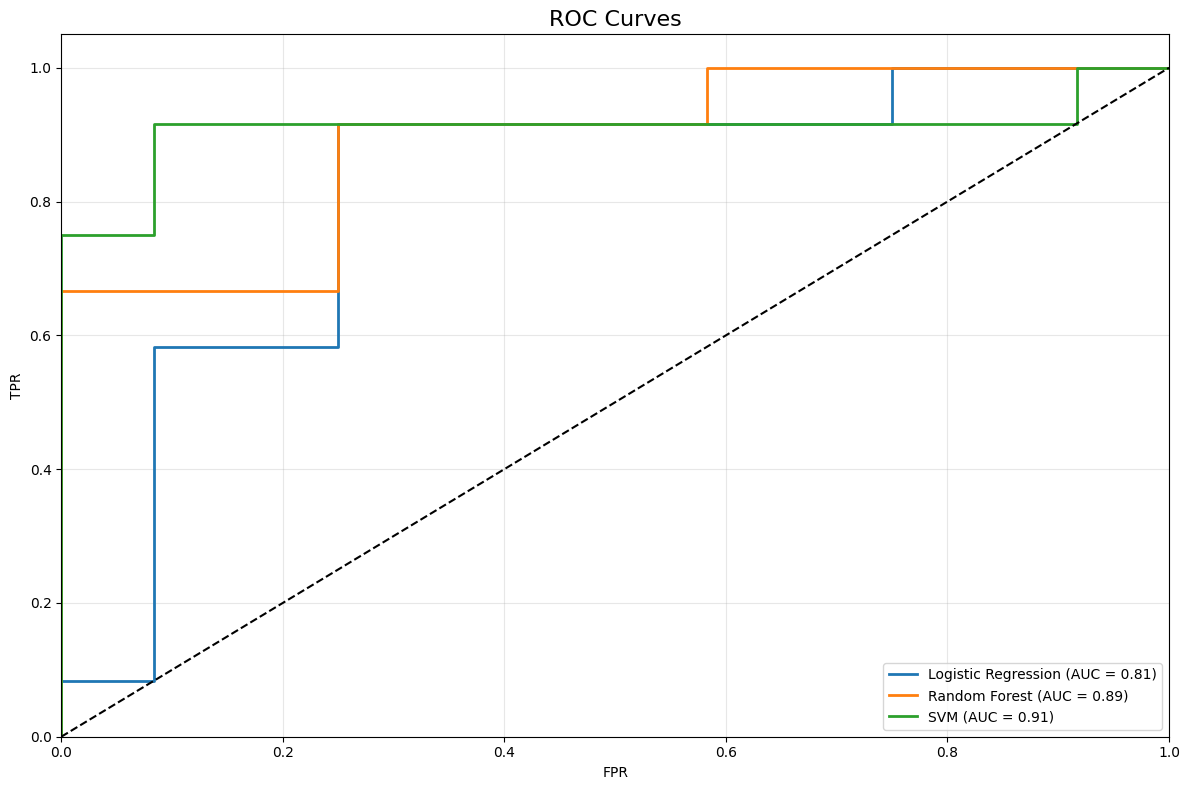

In [16]:
plt.figure(figsize=(12, 8))

for name in ['Logistic Regression', 'Random Forest', 'SVM']:
    if name in probabilities:
        fpr, tpr, _ = roc_curve(y_test, probabilities[name])
        auc_score = roc_auc_score(y_test, probabilities[name])
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curves', fontsize=16)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# матрицы ошибок

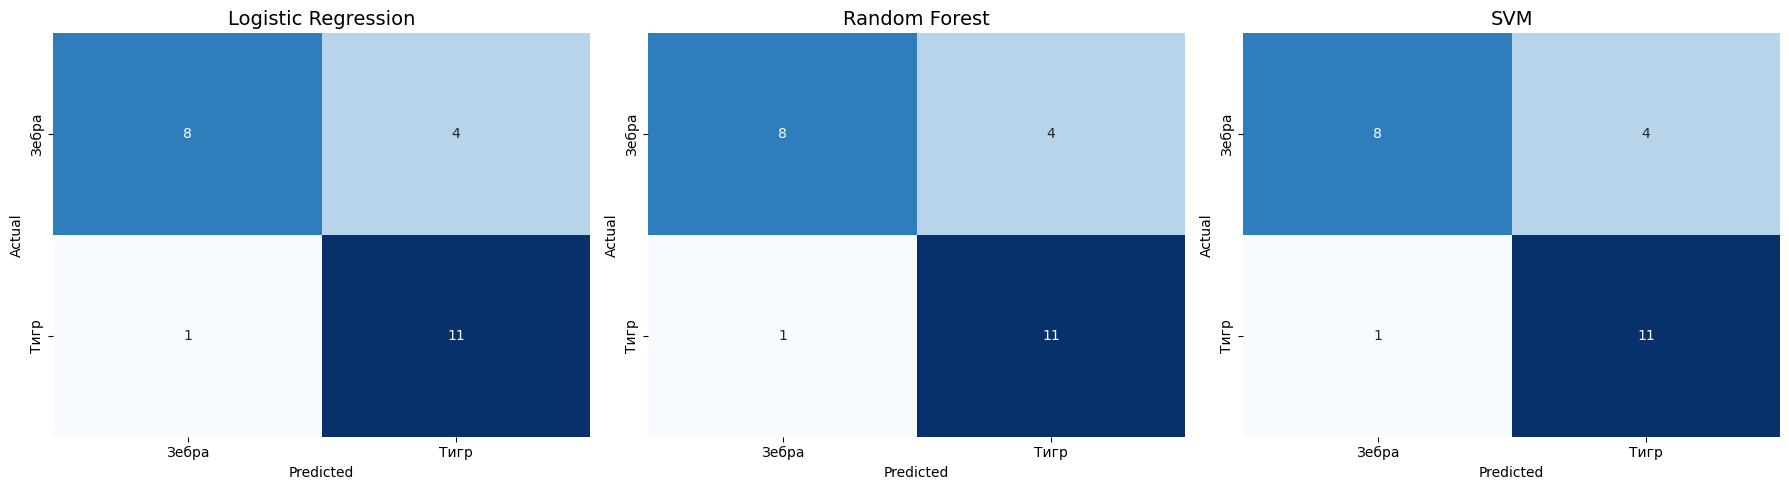

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, model_name in enumerate(models):
    y_pred = predictions[model_name]
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar = False,
                xticklabels=['Зебра', 'Тигр'],
                yticklabels=['Зебра', 'Тигр'],
                ax=axes[idx])

    accuracy = accuracy_score(y_test, y_pred)
    axes[idx].set_title(f'{model_name}', fontsize=14)
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [28]:
for name in models.keys():
    mask = y_pred != y_test.values

    misclassified_rows = X_test_save.loc[mask, ['filename', 'true_label']].copy()
    misclassified_rows['predicted'] = y_pred[mask]

    misclassified_rows['actual_class'] = misclassified_rows['true_label']
    misclassified_rows['predicted_class'] = misclassified_rows['predicted']

    print(f"\n{name}: {len(misclassified_rows)} из {len(y_test)} предсказаний ошибочны")
    if not misclassified_rows.empty:
        print(misclassified_rows[['filename', 'actual_class', 'predicted_class']].to_string(index=False))


Logistic Regression: 5 из 24 предсказаний ошибочны
     filename  actual_class  predicted_class
tiger_004.jpg             1                0
zebra_028.jpg             0                1
zebra_016.jpg             0                1
zebra_012.jpg             0                1
zebra_023.jpg             0                1

Random Forest: 5 из 24 предсказаний ошибочны
     filename  actual_class  predicted_class
tiger_004.jpg             1                0
zebra_028.jpg             0                1
zebra_016.jpg             0                1
zebra_012.jpg             0                1
zebra_023.jpg             0                1

SVM: 5 из 24 предсказаний ошибочны
     filename  actual_class  predicted_class
tiger_004.jpg             1                0
zebra_028.jpg             0                1
zebra_016.jpg             0                1
zebra_012.jpg             0                1
zebra_023.jpg             0                1


# ошибки

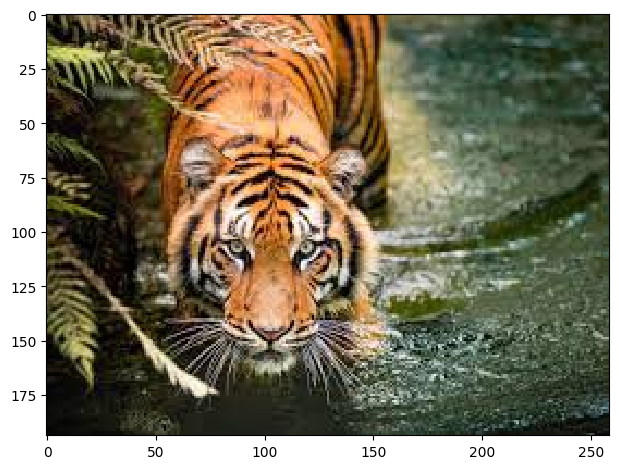

In [37]:
imshow(tiger_files[4])

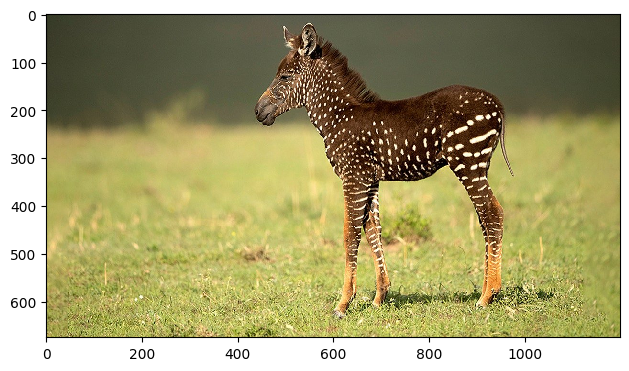

In [38]:
imshow(zebra_files[28])

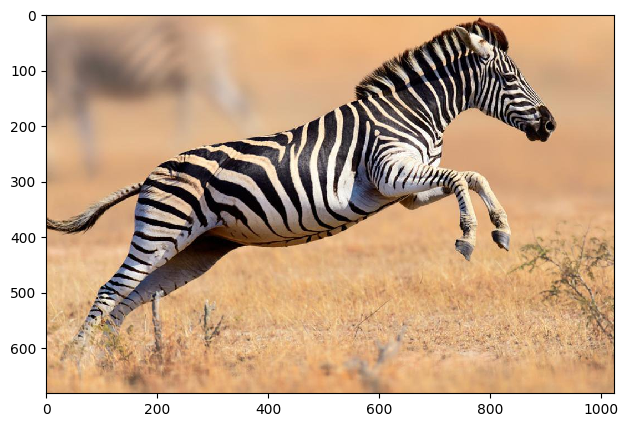

In [39]:
imshow(zebra_files[16])

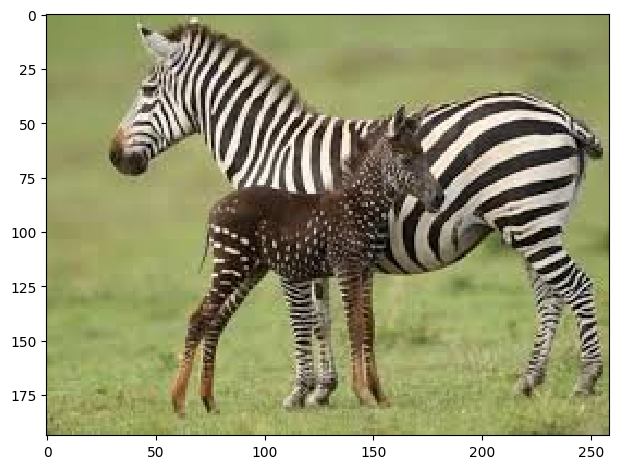

In [40]:
imshow(zebra_files[12])

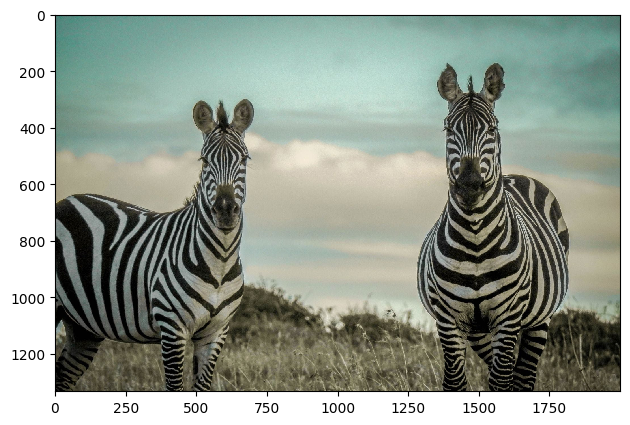

In [41]:
imshow(zebra_files[23])